In [1]:
pip install tinkoff-investments

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at d:\anaconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [2]:
pip install fastapi uvicorn

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at d:\anaconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [19]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_datareader as pdr
import csv

from datetime import date
from tinkoff.invest import CandleInterval, Client, InstrumentStatus
from tinkoff.invest.services import InstrumentsService, MarketDataService
from tinkoff.invest.schemas import CandleSource
from tinkoff.invest.utils import now
from datetime import timedelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf




In [20]:
TOKEN = "t.Gu3RbTine5HbBdjILk50gBAUjDjAH_Uc1uaFOsLSo28D9aUF9ET79J1QZUoYWjc07ZyhjRFQlxwrFcSl0EDVHw"

In [21]:
with Client(TOKEN) as client:
    with open('data.csv', mode='w', newline='') as file:
        fieldnames = ['Close']  # Заголовки столбцов
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        
        for candle in client.get_all_candles(
            instrument_id="BBG004RVFFC0",
            from_=now() - timedelta(days=2000),
            interval=CandleInterval.CANDLE_INTERVAL_DAY,
            candle_source_type=CandleSource.CANDLE_SOURCE_UNSPECIFIED,
        ):
            cand = candle.close.units
            writer.writerow({'Close': cand})

In [22]:
data_closed = pd.read_csv('data.csv')
print(data_closed)

      Close
0       719
1       714
2       714
3       710
4       703
...     ...
1360    685
1361    694
1362    691
1363    692
1364    695

[1365 rows x 1 columns]


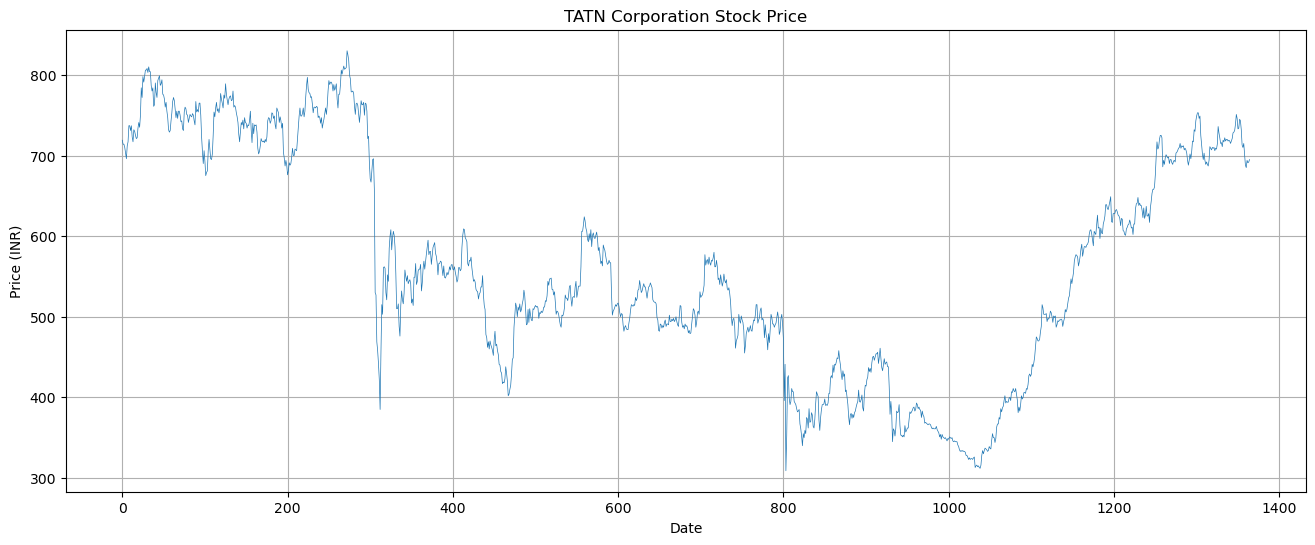

In [23]:
plt.figure(figsize=(16, 6))
plt.plot(data_closed['Close'], linewidth=0.5)
plt.title("TATN Corporation Stock Price")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.grid(True)
plt.show()

In [24]:
train = pd.DataFrame(data_closed[0:int(len(data_closed))])
# test = pd.DataFrame(data_closed[int(len(data_closed)*0.70): int(len(data_closed))])

print(train)
# print(test.shape)

      Close
0       719
1       714
2       714
3       710
4       703
...     ...
1360    685
1361    694
1362    691
1363    692
1364    695

[1365 rows x 1 columns]


In [25]:
# Делаем нормализацию данных
scaler = MinMaxScaler()
data_closed_scaled = pd.DataFrame(scaler.fit_transform(data_closed), columns=data_closed.columns) # применяем скалирование

In [26]:
data_closed_scaled

,Close
0,0.786948
1,0.777351
2,0.777351
3,0.769674
4,0.756238
...,...
1360,0.721689
1361,0.738964
1362,0.733205
1363,0.735125


In [27]:
# Выделяем сегмент для тренировки сети и сегмент для тестирования натренированной сети в отношении 1/4
train, test = train_test_split(data_closed_scaled, test_size=0.2, shuffle=False)

In [28]:
print(train.head())
print(test.head())

      Close
0  0.786948
1  0.777351
2  0.777351
3  0.769674
4  0.756238
         Close
1092  0.186180
1093  0.184261
1094  0.195777
1095  0.193858
1096  0.205374


In [29]:
# Определяем структуру нашей модели
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(None, 1))) # Первый слой - это LSTM сеть
model.add(Dense(1)) # второй слой - обычная линейная регрессия
model.compile(optimizer='adam', loss='mean_squared_error') # в качестве метода оптимизации используем стохастический градиентный метод, в качестве целевой функции среднюю квадратичную ошибку

D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [30]:
# Готовим данные для обучения сети
window_size = 10  # Выбираем размер окна для формирования предсказания
# Готовим тренировочные данные - выбираем окна размером 10 и для каждого окна ожидаемый результат 11-ое значение
X_train = np.array([train.iloc[i-window_size:i].values for i in range(window_size, len(train))])
y_train = train.iloc[window_size:, 0].values
# Аналогично готовим данные для проверки качества обучения сети
X_test = np.array([test.iloc[i-window_size:i].values for i in range(window_size, len(test))])
y_test = test.iloc[window_size:, 0].values
# Преобразовываем данные в формат входа LSTM модели
X_train = X_train.reshape(X_train.shape[0], window_size, 1)
X_test = X_test.reshape(X_test.shape[0], window_size, 1)

In [50]:
print(y_test)

[0.24760077 0.2571977  0.2706334  0.29558541 0.31861804 0.31477927
 0.30902111 0.30902111 0.31285988 0.33013436 0.34357006 0.39539347
 0.38771593 0.37236084 0.37236084 0.37236084 0.37428023 0.35508637
 0.36276392 0.36084453 0.36660269 0.38003839 0.37619962 0.36660269
 0.35316699 0.36852207 0.3646833  0.36852207 0.34165067 0.34740883
 0.35700576 0.35508637 0.35892514 0.35892514 0.36084453 0.35892514
 0.34357006 0.35508637 0.36276392 0.38387716 0.378119   0.38387716
 0.39731286 0.41074856 0.41650672 0.43761996 0.45681382 0.4452975
 0.45873321 0.47216891 0.49904031 0.50863724 0.51439539 0.51247601
 0.50863724 0.48752399 0.49712092 0.51055662 0.52783109 0.53934741
 0.51055662 0.52207294 0.53358925 0.53358925 0.53166987 0.53742802
 0.53934741 0.54510557 0.56238004 0.57197697 0.57389635 0.56429942
 0.54894434 0.53550864 0.57005758 0.56621881 0.56238004 0.58541267
 0.6084453  0.57773512 0.57965451 0.55278311 0.57773512 0.56621881
 0.56429942 0.58733205 0.5950096  0.60652591 0.63339731 0.63339

In [32]:
# Обучаем модель
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2197 - val_loss: 0.0109
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0119 - val_loss: 0.0015
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042 - val_loss: 0.0018
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 9/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 10/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - val_loss: 9.7420e-04


In [35]:
model.save('keras_model.keras')

In [36]:
# Вычисляем отклонение по целевой функции
train_loss = model.evaluate(X_train, y_train)
test_loss = model.evaluate(X_test, y_test)
print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0020 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.5548e-04 
Train Loss: 0.0017901663668453693
Test Loss: 0.0009741991525515914


In [44]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

In [53]:
print(X_test)

[[[0.18618042]
  [0.18426104]
  [0.19577735]
  ...
  [0.22456814]
  [0.2303263 ]
  [0.25335893]]

 [[0.18426104]
  [0.19577735]
  [0.19385797]
  ...
  [0.2303263 ]
  [0.25335893]
  [0.24760077]]

 [[0.19577735]
  [0.19385797]
  [0.20537428]
  ...
  [0.25335893]
  [0.24760077]
  [0.2571977 ]]

 ...

 [[0.83685221]
  [0.83301344]
  [0.81190019]
  ...
  [0.72744722]
  [0.72168906]
  [0.73896353]]

 [[0.83301344]
  [0.81190019]
  [0.77543186]
  ...
  [0.72168906]
  [0.73896353]
  [0.73320537]]

 [[0.81190019]
  [0.77543186]
  [0.7696737 ]
  ...
  [0.73896353]
  [0.73320537]
  [0.73512476]]]


In [51]:
y_pred = model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


In [52]:
print(y_pred)

[[0.23693469]
 [0.24356048]
 [0.2506059 ]
 [0.25794086]
 [0.26766714]
 [0.2804886 ]
 [0.29215142]
 [0.30111355]
 [0.30868778]
 [0.3153375 ]
 [0.32121935]
 [0.32686162]
 [0.33999538]
 [0.3527742 ]
 [0.36260974]
 [0.37049875]
 [0.37505898]
 [0.37559384]
 [0.37325397]
 [0.3729266 ]
 [0.37192777]
 [0.37144148]
 [0.3722483 ]
 [0.37355494]
 [0.37481466]
 [0.37308553]
 [0.3730787 ]
 [0.3714627 ]
 [0.37101072]
 [0.3671062 ]
 [0.3645256 ]
 [0.36381796]
 [0.36184397]
 [0.36091897]
 [0.36087915]
 [0.36325496]
 [0.36421454]
 [0.36216265]
 [0.36150432]
 [0.36232919]
 [0.36631808]
 [0.36964148]
 [0.37423226]
 [0.38156763]
 [0.38908693]
 [0.39567235]
 [0.4052919 ]
 [0.41759405]
 [0.42616433]
 [0.43489355]
 [0.44320878]
 [0.4536648 ]
 [0.46602046]
 [0.47761783]
 [0.48637107]
 [0.4913246 ]
 [0.49096802]
 [0.49098414]
 [0.49346584]
 [0.49902382]
 [0.5076382 ]
 [0.5098976 ]
 [0.51140696]
 [0.51226217]
 [0.5140761 ]
 [0.5176319 ]
 [0.52131206]
 [0.52392507]
 [0.5269054 ]
 [0.531993  ]
 [0.53790015]
 [0.54

In [54]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
mae_percentage = (mae / np.mean(y_test)) * 100
print("Mean absolute error on test set: {:.2f}%".format(mae_percentage))

Mean absolute error on test set: 3.90%


In [56]:
from sklearn.metrics import r2_score

# Actual values
actual = y_test

# Predicted values
predicted = y_pred

# Calculate the R2 score
r2 = r2_score(actual, predicted)

print("R2 score:", r2)

R2 score: 0.9604749112173234


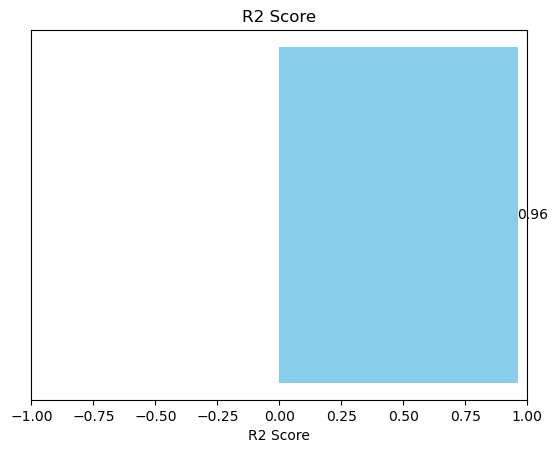

In [57]:
# Plotting the R2 score
fig, ax = plt.subplots()
ax.barh(0, r2, color='skyblue')
ax.set_xlim([-1, 1])
ax.set_yticks([])
ax.set_xlabel('R2 Score')
ax.set_title('R2 Score')

# Adding the R2 score value on the bar
ax.text(r2, 0, f'{r2:.2f}', va='center', color='black')

plt.show()

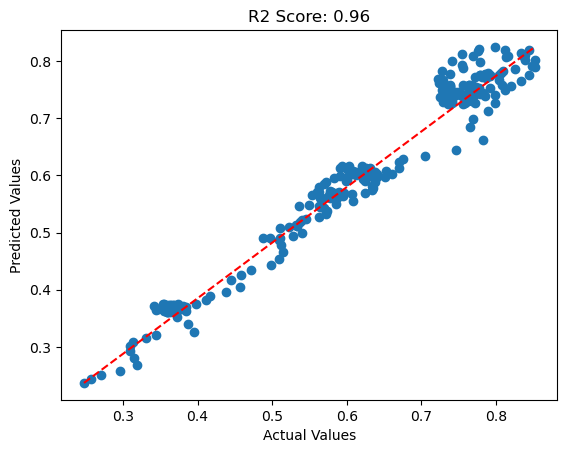

In [58]:
plt.scatter(actual, predicted)
plt.plot([min(actual), max(actual)], [min(predicted), max(predicted)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'R2 Score: {r2:.2f}')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
714.6269
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
716.1638
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
718.3185
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
718.2933
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
717.2032
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
719.6959
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
723.2983
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
723.9722
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
723.0715
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
721.2468


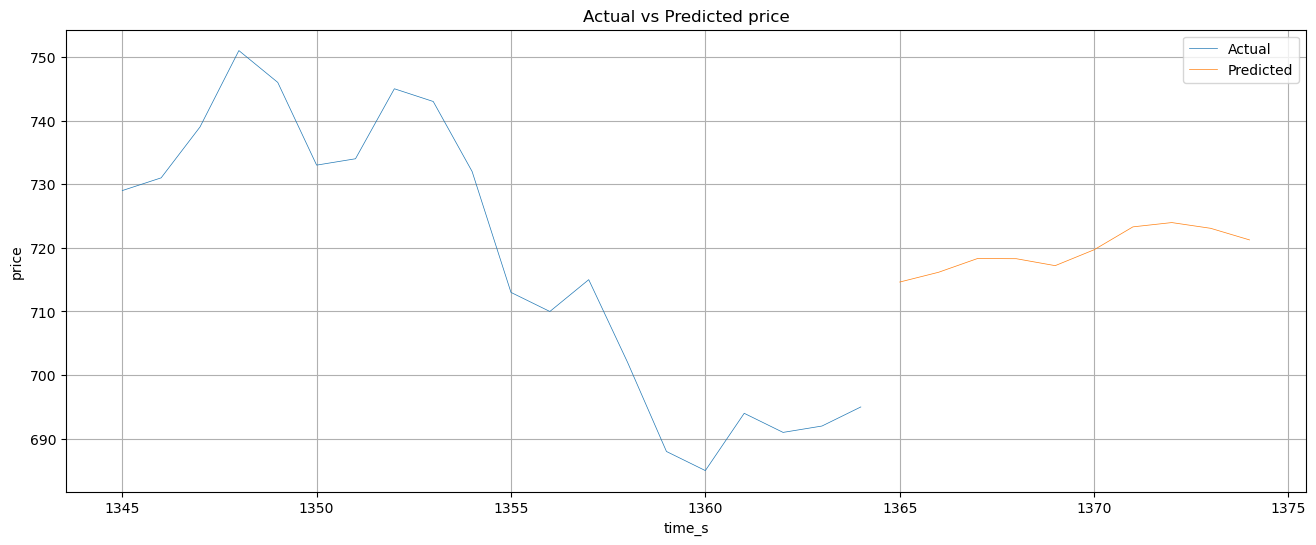

In [38]:
# Делаем прогноз
window_size = 10 

# Создаем список для хранения прогнозов
forecasts = []

# Текущий индекс в массиве данных
current_index = 0

# Индекс последнего элемента в выборке
last_element_index = len(data_closed_scaled)-1

# Проходим по всем данным, используя сдвигающиеся окна
while current_index < 10:
    # Выбираем данные для прогнозирования
    recent_data = data_closed_scaled['Close'][current_index:last_element_index]

    # Преобразуем данные в нужный формат для модели
    recent_data = np.resize([(recent_data)], window_size).reshape(1, window_size, 1)
    
    # Делаем прогноз
    predicted_value_scaled = model.predict(recent_data)
    
    # Преобразуем обратно в исходное значение
    predicted_value = scaler.inverse_transform(predicted_value_scaled)
    
    # Получаем голое значение без скобок и всего подобного
    predicted_value_single = predicted_value.item()
    
    # Ограничиваем количество знаков после запятой до 4 с помощью форматирования строк
    predicted_value_single_formatted = "{:.4f}".format(predicted_value_single)
    print(predicted_value_single_formatted)
    
    # Добавляем прогноз в список результатов, преобразовав обратно в float
    forecasts.append(float(predicted_value_single_formatted))
    
    # Увеличиваем текущий индекс и обновляем индекс последнего элемента
    current_index += 1
    last_element_index = current_index + window_size


forecasts
real_data = data_closed['Close']
forecasts = np.squeeze(forecasts)
predicted_df = pd.DataFrame(forecasts, columns=['Predicted'], index=range(len(data_closed), len(data_closed) + len(forecasts)))

# Объединяем реальные данные и прогнозы в один DataFrame
combined_data = pd.concat([real_data.tail(20), predicted_df], axis=1)

# Устанавливаем заголовки для столбцов
combined_data.columns = ['Actual', 'Predicted']

# Создаем график
plt.figure(figsize=(16, 6))
plt.plot(combined_data, linewidth=0.5)
plt.title('Actual vs Predicted price')
plt.xlabel('time_s')
plt.ylabel('price')
plt.legend(['Actual', 'Predicted'])
plt.grid()
plt.show()

In [24]:
from fastapi import FastAPI
from pydantic import BaseModel
import numpy as np
import tensorflow as tf
import os
import nest_asyncio
import uvicorn

nest_asyncio.apply()

app = FastAPI()

# Укажите путь к вашей модели
MODEL_PATH = 'keras_model.keras'

# Проверьте, существует ли файл модели
if not os.path.exists(MODEL_PATH):
   raise FileNotFoundError(f"Model file not found at {MODEL_PATH}")

# Загрузите вашу модель
model = tf.keras.models.load_model(MODEL_PATH)

class PredictionRequest(BaseModel):
   input: list

@app.post("/predict")
async def predict(request: PredictionRequest):
   input_data = np.array(request.input).reshape(1, -1)
   prediction = model.predict(input_data)
   return {"prediction": prediction.tolist()}

if __name__ == "__main__":
       config = uvicorn.Config(app, host="0.0.0.0", port=8000)
       server = uvicorn.Server(config)
       server.run()

INFO:     Started server process [9684]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [9684]
